<h1 style="text-align:center;"> LSTM for Stock Market Prediction</h1>
<h2 style="text-align:center;"> TESLA</h2>

<p style="font-size:18px;color:gray;"> <strong>Step 1:</strong> For this Predictive model we will utilize some modules that are necessary to obtain, create and visualize this predictive model such as <span class="py-modules">sqlalchemy</span>, <span class="py-modules">NumPy</span>, <span class="py-modules">Pandas</span>, <span class="py-modules">SciKitlearn</span>, <span class="py-modules">MatPlotLib</span>, and <span class="py-modules">Keras</span>.</p>

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import datetime as dt
import requests
from sqlalchemy import create_engine
from config import password

<p style="font-size:18px;color:gray;"> <strong style="line-height: 0px;">Step 2:</strong> </p> <p style="font-size:18px;color:gray;line-height:normal;"> Now, we start building our model by first defining the dataset that the model will train on. We're using datasets from NASDAQ provided by <a href="https://financialmodelingprep.com">https://financialmodelingprep.com</a>. For this example were using <span class="py-modules">Tesla TSL</span> historical data.

 <p style="font-size:18px;color:gray;"> after pulling the data from our SQL database we read it using the the csv bultin function included in the Pandas library.</p>

In [2]:
# Connecting to Database
connection_string = f"ofygklqv:{password}@batyr.db.elephantsql.com:5432/ofygklqv"
engine = create_engine(f'postgresql://{connection_string}', pool_size=2, pool_recycle=1200, connect_args={'connect_timeout': 10},
client_encoding="utf8", pool_pre_ping=True)

In [3]:
ticker = "TSLA"
df = pd.read_sql_query('select * from ticker', con=engine)
id = df[df['symbol']==ticker]['stock_id'].values[0] # returning ID for the specified ticker(symbol)
df = pd.read_sql_query(f'select * from stock WHERE stock_id = {id}', con=engine)
print(df.shape)
df["date"]=pd.to_datetime(df.date,format="%Y-%m-%d")
df.index = df['date']
df = df[["close"]]

(1258, 7)


In [4]:
print(df[df.duplicated()])

                close
date                 
2016-08-01  46.001999
2016-08-04  46.122002
2016-10-20  39.820000
2017-08-01  63.914001
2017-09-01  71.080002
2017-09-28  67.919998
2017-10-18  71.930000
2017-11-10  60.598000
2017-12-05  60.740002
2018-04-27  58.816002
2018-07-02  67.014000
2018-07-25  61.748001
2018-11-16  70.862000
2019-02-05  64.269997
2019-03-07  55.318001
2019-08-12  45.801998
2019-08-14  43.924000
2019-08-30  45.122002
2019-10-21  50.700001
2019-10-24  59.936001
2019-11-05  63.444000
2019-11-12  69.986000


In [5]:
df[df.index == "2019-06-20"]

,close
date,
2019-06-20,43.924


#### Sort date and close
<p style="font-size:14px;color:gray;"> Since the dates and values are in descending order(</p>

In [6]:
df = df.iloc[::-1]
df

,close
date,
2021-07-02,678.900024
2021-07-01,677.919983
2021-06-30,679.700012
2021-06-29,680.760010
2021-06-28,688.719971
...,...
2016-07-12,44.930000
2016-07-11,44.956001
2016-07-08,43.355999


<p style="font-size:18px;color:gray;"> <strong style="line-height: 0px;">Step 3: Plotting the close prices</strong> </p> <p style="font-size:18px;color:gray;line-height:normal;">We'll plot the close prices using "Close" values as our dependent variable and Date as our independent variable(this is time scale).</p>

Text(0, 0.5, 'Close Price USD')

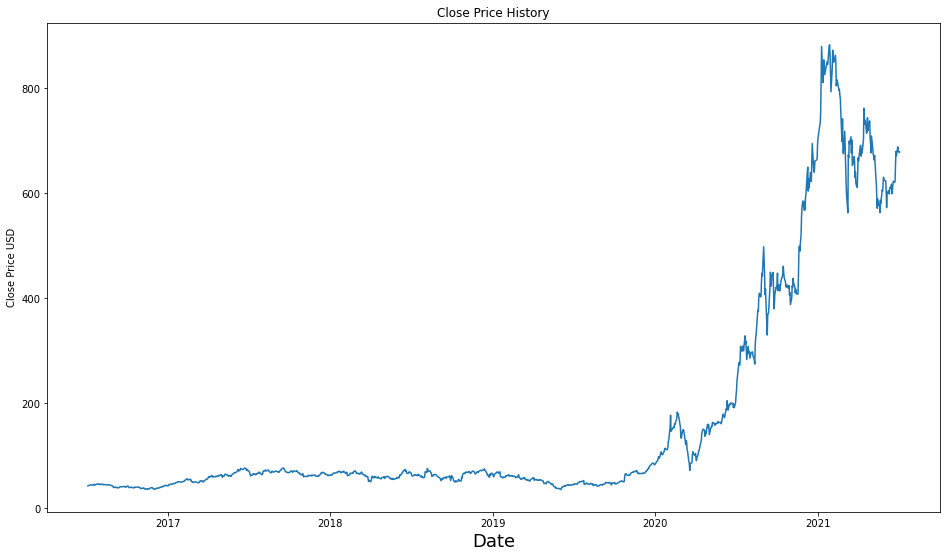

In [7]:
plt.figure(figsize=(16,9))
plt.title("Close Price History")
plt.plot(df['close'])
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD")

In [8]:
# Create New DataFrame with close values
data = df
# Convert Dataframe to Numpy array
dataset = data.values

In [9]:
#Get number of row to train our module
training_data_len = math.ceil(len(dataset) * 0.80)
training_data_len

1007

In [10]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.75900984],
       [0.75785317],
       [0.75995401],
       ...,
       [0.00892486],
       [0.00872659],
       [0.00837252]])

In [11]:
# Create training Dataset
#create the scaled Training Data Set
train_data = scaled_data[0:training_data_len,:]
#split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
  if i<=60:
    print(x_train)
    print(y_train)
    print()

[array([0.75900984, 0.75785317, 0.75995401, 0.76120504, 0.77059959,
       0.75071283, 0.76009563, 0.7326554 , 0.69387322, 0.69047417,
       0.6934011 , 0.68548177, 0.67163775, 0.6651347 , 0.68676824,
       0.6775625 , 0.67783393, 0.66445022, 0.6701271 , 0.67194462,
       0.66476883, 0.63383518, 0.6719328 , 0.69409747, 0.6956553 ,
       0.70229997, 0.68846777, 0.67142532, 0.67349071, 0.64332416,
       0.65028752, 0.62276466, 0.63977167, 0.63854426, 0.65378094,
       0.63247789, 0.653958  , 0.68618994, 0.70016377, 0.75130294,
       0.74088153, 0.74961523, 0.75275459, 0.76609119, 0.79505389,
       0.75676739, 0.77730333, 0.78950682, 0.82899717, 0.81861121,
       0.8071512 , 0.83598409, 0.80632503, 0.80117926, 0.83086195,
       0.82976428, 0.82195119, 0.8574642 , 0.78624939, 0.75679101])]
[0.7647929030180372]



In [12]:
# convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [13]:
samples,time_steps = x_train.shape
print(samples,time_steps)

947 60


In [14]:
# Reshaping the data
x_train = np.reshape((x_train),(samples,time_steps,1))
x_train.shape

(947, 60, 1)

In [15]:
# Building the LSTM Model
model = Sequential()
# Creating Layers
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps,1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [16]:
# Compiling the model
# Loss function is used to measure how well the model did on training.
model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
#training the Model
# Batch size is the total number of training examples present in a single batch
# Epoch is the iterations when an entire dataset is passed forward and backward through a neural network
model.fit(x_train, y_train, batch_size=1, epochs=2,verbose=5)

Epoch 1/2
Epoch 2/2


In [18]:
# creating the Testing dataset 
# Array that contained scaled values test_data = scaled_data[training_data_len - 60:through the end, all columns]

test_data = scaled_data[training_data_len-60: , :]
# Creating testing datasets 
x_test = []
y_test = dataset[training_data_len: , :]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i,0])
  


In [19]:
# Converting data to a numpy Array
x_test = np.array(x_test)


In [20]:
# Reshaping the data, because LST model is expecting a 3 dimensional array
# x_test.shape[0] represents the number of Rows, 
#  x_test.shape[1] represents the number of time steps
# 3rd element in the dimensional array (1) represents the close price
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [21]:
# Get the models predicted price values
# This step "unscale" the values

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


Model Evaluation

In [22]:
# Evaluating our model, Getting the root mean error (RMSE), Model accuracy 
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

11.139401971581448

Plotting the Data


In [23]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['predictions'] = predictions

C:\Users\admin\anaconda3\envs\PythonAdv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


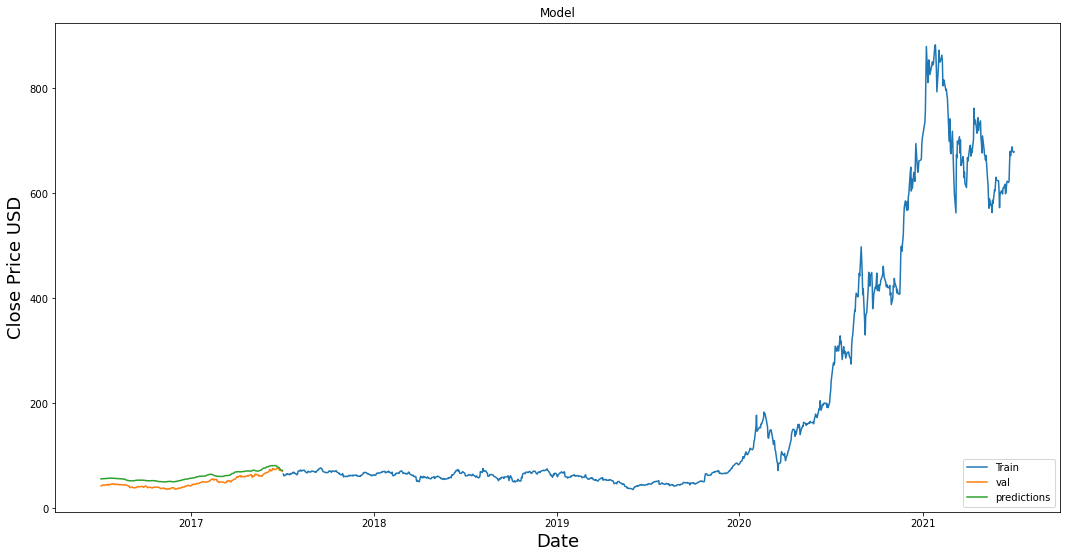

In [24]:
# Visualize the models data
plt.figure(figsize=(18,9))
plt.title('Model')
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD", fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close','predictions']])
plt.legend(['Train','val','predictions'], loc='lower right')
plt.show()

In [25]:
# show the Valid(actual prices) and the predicted prices
valid

,close,predictions
date,,
2017-07-03,70.524002,72.290459
2017-06-30,72.321999,72.968697
2017-06-29,72.150002,74.159592
2017-06-28,74.248001,75.434059
2017-06-27,72.473999,76.798737
...,...,...
2016-07-12,44.930000,56.503147
2016-07-11,44.956001,56.479908
2016-07-08,43.355999,56.504372


In [26]:
# Predicting 